In [ ]:
#default_exp exhaustive_training

# 70-exhaustive-training
> Create systematic testing procedure and document conclusions

**Purpose**  The purpose of this notebook is to provide comprehensive testing with respect to:
1. Hyper-parameters (learning rate, dropout rate, compounding, etc)
2. Training data: this includes varying language (Spanish, Portuguese) and record type (baptismal, burial, and marriage)

Errors I'm Getting:
1. C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
2. C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)

In [ ]:
#no_test

#data structure imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

#python imports
import random

#modeling imports
from spacy.util import fix_random_seed
from ssda_nlp.collate import *
from ssda_nlp.split_data import *
from ssda_nlp.modeling import *
from ssda_nlp.preprocessing import *
from ssda_nlp.model_performance_utils import *

In [ ]:
#no_test
#if you want the same model everytime:
seed = 2436
random.seed(seed)
fix_random_seed(seed)

# Available Training Data
    1. 15834_annot.jsonl:                Baptism, Cuba
    2. 239746_annot.jsonl:               Baptism, Florida
    3. 419324_annot.jsonl:               Baptism, Colombia
    4. 701075_annot.jsonl:               Baptism, Brazil
    5. deathandbirthdata.jsonl:          ?
    6. guatemala.annotations.jsonl:      ?

In [ ]:
collated_df1 = prodigy_output_to_collated_df("transcriptions/15834_annot.jsonl")
collated_df2 = prodigy_output_to_collated_df("transcriptions/239746_annot.jsonl")
collated_df3 = prodigy_output_to_collated_df("transcriptions/419324_annot.jsonl")

collated_df = collated_df1

print(collated_df1.shape)
print(collated_df2.shape)
print(collated_df3.shape)

display(collated_df1.head())
display(collated_df2.head())
display(collated_df3.head())

(2206, 6)
(2839, 6)
(947, 6)


,entry_no,text,entity,start,end,label
0,1,[margin]: Juana. Esc.va Domingo veinte y dos d...,Juana,10,15,PER
1,1,[margin]: Juana. Esc.va Domingo veinte y dos d...,Esc.va,17,23,CHAR
2,1,[margin]: Juana. Esc.va Domingo veinte y dos d...,Domingo veinte y dos de [roto] y nueve,24,62,DATE
3,1,[margin]: Juana. Esc.va Domingo veinte y dos d...,Thomas de Orvera,66,82,PER
4,1,[margin]: Juana. Esc.va Domingo veinte y dos d...,Juana,121,126,PER


,entry_no,text,entity,start,end,label
0,1,"1. María Dolores Sanchez Lunes, día veinte y u...",María Dolores Sanchez,3,24,PER
1,1,"1. María Dolores Sanchez Lunes, día veinte y u...","Lunes, día veinte y uno de Octubre de Mil Sete...",25,94,DATE
2,1,"1. María Dolores Sanchez Lunes, día veinte y u...",Don Miguel o’Reilly,98,117,PER
3,1,"1. María Dolores Sanchez Lunes, día veinte y u...","Teniente de Cura Beneficiado,",118,147,CHAR
4,1,"1. María Dolores Sanchez Lunes, día veinte y u...",Vicario,148,155,CHAR


,entry_no,text,entity,start,end,label
0,1,Partida 8236 En esta Santa Iglecia de Santa Cr...,Santa Iglecia de Santa Cruz de Lorica,21,58,LOCATION
1,1,Partida 8236 En esta Santa Iglecia de Santa Cr...,veinte de Mayo de mil ochocien tos ochenta y c...,61,111,DATE
2,1,Partida 8236 En esta Santa Iglecia de Santa Cr...,José Maria Lugo,129,144,PERSON
3,1,Partida 8236 En esta Santa Iglecia de Santa Cr...,Eva Justina,182,193,PERSON
4,1,Partida 8236 En esta Santa Iglecia de Santa Cr...,cuatro de Febrero,207,224,DATE


In [ ]:
#no_test

collated_df = prodigy_output_to_collated_df("transcriptions/15834_annot.jsonl")
# Split data
train_df, valid_df, test_df = split_data_grp(collated_df, prop_train = 0.7, prop_validation = 0.2, grp_var = 'entry_no', seed=seed)
# Generate Spacy datasets
train_spacy = genSpaCyInput(train_df)
# Look at column names
train_df.head(10)

,entry_no,text,entity,start,end,label
13,2,[margin]: Paula. Esc.a Juebes veinte y tres de...,Paula,10,15,PER
14,2,[margin]: Paula. Esc.a Juebes veinte y tres de...,Esc.a,17,22,CHAR
15,2,[margin]: Paula. Esc.a Juebes veinte y tres de...,Juebes veinte y tres de feb.o de mil sietec.to...,23,86,DATE
16,2,[margin]: Paula. Esc.a Juebes veinte y tres de...,Thomas de Orvera,90,106,PER
17,2,[margin]: Paula. Esc.a Juebes veinte y tres de...,Paula,145,150,PER
18,2,[margin]: Paula. Esc.a Juebes veinte y tres de...,h. l.16,151,158,CHAR
19,2,[margin]: Paula. Esc.a Juebes veinte y tres de...,Juan Joseph,162,173,PER
20,2,[margin]: Paula. Esc.a Juebes veinte y tres de...,Maria Josepha,177,190,PER
21,2,[margin]: Paula. Esc.a Juebes veinte y tres de...,esc.s,191,196,CHAR
22,2,[margin]: Paula. Esc.a Juebes veinte y tres de...,Capitan D. Luis Hurtado de Mendoza,201,235,PER


In [ ]:
#no_test
#Functioning code that this was all based off of

#spacy parameters
#cping = {'start':16, 'end':32, 'cp_rate':1.05}
#solves = {'learn_rate':0.001}
#dpout = 0.6
#save_mdir = 'models/exhaustive_models'

#load model from pretrained
#nlp_model = load_model()

#nlp_model, perf_df = model_meta_training(nlp_model, train_spacy, valid_df, verbose=True, save_dir = save_mdir,
#                                                 n_iter=10, solver_params=solves, compound_params=cping, dropout=dpout)
        
#display('Successful run')

# Plan
1. Run lots of trials varying learning rate and dropout, get a sense of what ranges might be the best
2. Repeat the above, but focused in on the identified areas
3. Repeat, but instead of varying hyper parameters, vary the training data

In [ ]:
#no_test

#if you want the same model everytime:
#random.seed(seed)
#fix_random_seed(seed)

#spacy parameters setup
my_lr = [0.0001, 0.001, 0.01, 0.1]
my_dps = [0.1, 0.3, 0.5, 0.7, 0.9]

#spacy parameters
for i in range(len(my_lr)):
    cping = {'start':16, 'end':32, 'cp_rate':1.05}
    solves = {'learn_rate':my_lr[i]} #Original 0.001
    for j in range(len(my_dps)):
        dpout = my_dps[j] #Original 0.6
        save_mdir = 'models/exhaustive_models'

        #load model from pretrained
        nlp_model = load_model()

        nlp_model, perf_df = model_meta_training(nlp_model, train_spacy, valid_df, verbose=True, save_dir = save_mdir,
                                                 n_iter=10, solver_params=solves, compound_params=cping, dropout=dpout)
    
        perf_df['learning rate'] = my_lr[i]
        perf_df['dropout'] = my_dps[j]
        perf_df['compounding rate'] = cping['cp_rate']
        #Basis: schoolCopy = schoolDataFrame[allTheColumnsRequired].copy(deep=True)
        history_df = perf_df.copy(deep=True)
        
        #Going back and fixing this so taht history_df is iterative
        
        
display('Successful run')

C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,6337.012493,0.0,0.0,0.0


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,3406.105111,0.0,0.0,0.0


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,3322.549372,29.906542,7.256236,11.678832


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,3896.569783,54.901961,31.746032,40.229885


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,3208.278305,57.94702,39.68254,47.106326


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,2956.632461,59.82659,46.938776,52.604828


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,7.0,2250.887853,67.091837,59.637188,63.145258


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,8.0,1474.281023,76.997579,72.108844,74.473068


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,9.0,952.62034,83.062645,81.179138,82.110092


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,10.0,586.005209,85.454545,85.260771,85.357548


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,11.0,373.578572,87.243736,86.848073,87.045455


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,12.0,246.998869,87.556561,87.755102,87.655719


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,13.0,145.481001,87.358916,87.755102,87.556561


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,14.0,97.098373,88.208617,88.208617,88.208617


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,15.0,68.853311,86.800895,87.981859,87.387387


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,16.0,46.34059,88.539326,89.342404,88.939052


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,17.0,32.048167,87.723214,89.115646,88.413948


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,18.0,24.991888,87.777778,89.569161,88.664422


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,19.0,19.645166,89.63964,90.249433,89.943503


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,20.0,10.563601,88.789238,89.795918,89.289741


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,21.0,6.1098,89.164786,89.569161,89.366516


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,22.0,7.429566,89.864865,90.47619,90.169492


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,23.0,7.057022,89.485459,90.702948,90.09009


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,24.0,2.912577,89.111111,90.929705,90.011223


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,25.0,3.922831,89.910314,90.929705,90.417136


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,26.0,2.224605,89.285714,90.702948,89.988751


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,27.0,1.952308,89.532294,91.156463,90.337079


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,28.0,2.253366,89.333333,91.156463,90.23569


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,29.0,1.81047,89.555556,91.38322,90.460157


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,30.0,2.407013,88.962472,91.38322,90.1566


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,31.0,0.983707,89.578714,91.609977,90.58296


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,32.0,1.076579,89.309577,90.929705,90.11236


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,33.0,0.329539,89.977728,91.609977,90.786517


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,34.0,0.84008,89.532294,91.156463,90.337079


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,35.0,0.64564,89.333333,91.156463,90.23569


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,36.0,0.289578,88.864143,90.47619,89.662921


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,37.0,0.011229,88.495575,90.702948,89.585666


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,38.0,0.033439,89.183223,91.609977,90.380313


Performance hasn't improved for 5 cycles...
Done training after 38 meta cycles.


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,6977.451136,0.0,0.0,0.0


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,3707.842195,0.0,0.0,0.0


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,3297.711341,0.0,0.0,0.0


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,3147.184522,36.206897,4.761905,8.416834


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,3653.090671,44.827586,14.739229,22.1843


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,3731.74351,38.545455,24.036281,29.608939


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,7.0,3762.480967,47.468354,34.013605,39.630119


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,8.0,3425.598915,53.481894,43.537415,48.0


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,9.0,3037.844673,61.654135,55.782313,58.571429


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,10.0,2606.579244,66.829268,62.131519,64.39483


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,11.0,2018.462029,70.167064,66.666667,68.372093


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,12.0,1652.719754,75.644028,73.24263,74.423963


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,13.0,1376.338909,83.098592,80.272109,81.6609


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,14.0,1061.087137,83.72093,81.632653,82.663605


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,15.0,822.962632,84.848485,82.539683,83.678161


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,16.0,696.0805,86.1678,86.1678,86.1678


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,17.0,593.471732,86.681716,87.07483,86.877828


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,18.0,520.10696,87.954545,87.755102,87.854711


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,19.0,461.571841,88.261851,88.662132,88.461538


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,20.0,412.55883,89.090909,88.888889,88.989784


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,21.0,367.813237,89.090909,88.888889,88.989784


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,22.0,312.120443,88.888889,88.888889,88.888889


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,23.0,292.321369,89.616253,90.022676,89.819005


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,24.0,249.220816,89.366516,89.569161,89.467724


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,25.0,224.983835,90.045249,90.249433,90.147225


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,26.0,202.646527,90.045249,90.249433,90.147225


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,27.0,184.830261,89.237668,90.249433,89.740699


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,28.0,159.283917,89.59276,89.795918,89.694224


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,29.0,162.486428,90.249433,90.249433,90.249433


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,30.0,137.10802,90.497738,90.702948,90.600227


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,31.0,119.723462,90.888383,90.47619,90.681818


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,32.0,106.878435,90.744921,91.156463,90.950226


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,33.0,113.109523,90.970655,91.38322,91.176471


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,34.0,108.88051,90.358744,91.38322,90.868095


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,35.0,95.670619,90.888383,90.47619,90.681818


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,36.0,86.688248,90.540541,91.156463,90.847458


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,37.0,77.226738,90.358744,91.38322,90.868095


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,38.0,74.776571,89.910314,90.929705,90.417136


Performance hasn't improved for 5 cycles...
Done training after 38 meta cycles.


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,7400.596791,0.0,0.0,0.0


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,3760.855305,0.0,0.0,0.0


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,3825.764739,0.0,0.0,0.0


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,3469.316657,0.0,0.0,0.0


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,3258.677348,15.384615,0.453515,0.881057


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,3547.444283,16.129032,2.267574,3.976143


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,7.0,3723.227129,42.307692,9.977324,16.146789


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,8.0,3466.999406,51.801802,26.077098,34.690799


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,9.0,3731.958619,48.4375,28.117914,35.581062


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,10.0,3875.053674,45.819398,31.06576,37.027027


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,11.0,3802.538037,45.645646,34.46712,39.276486


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,12.0,3770.715874,47.008547,37.414966,41.666667


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,13.0,3594.027584,51.48248,43.310658,47.044335


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,14.0,3493.166684,56.13577,48.752834,52.184466


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,15.0,3384.476571,57.068063,49.433107,52.976914


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,16.0,3226.220656,57.21519,51.247166,54.066986


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,17.0,3021.413143,58.168317,53.287982,55.621302


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,18.0,2822.82342,61.234568,56.235828,58.628842


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,19.0,2611.972859,65.291262,60.997732,63.071512


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,20.0,2440.395415,66.825776,63.492063,65.116279


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,21.0,2241.114228,69.451074,65.986395,67.674419


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,22.0,2075.743003,69.811321,67.120181,68.439306


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,23.0,1982.000169,73.696682,70.521542,72.07416


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,24.0,1905.554346,75.714286,72.108844,73.867596


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,25.0,1770.558719,75.117371,72.562358,73.817762


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,26.0,1662.564379,77.19715,73.696145,75.406032


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,27.0,1572.613643,77.985948,75.510204,76.728111


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,28.0,1450.265462,80.0,77.097506,78.52194


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,29.0,1370.053454,81.074766,78.684807,79.86191


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,30.0,1269.247113,82.051282,79.818594,80.91954


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,31.0,1204.202189,82.750583,80.498866,81.609195


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,32.0,1086.859959,83.488372,81.405896,82.433984


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,33.0,1037.807758,84.064665,82.539683,83.295195


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,34.0,962.995179,86.046512,83.900227,84.959816


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,35.0,921.943035,85.87963,84.126984,84.994273


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,36.0,894.814927,85.681293,84.126984,84.897025


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,37.0,851.735083,86.143187,84.580499,85.354691


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,38.0,786.316863,85.977011,84.807256,85.388128


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,39.0,786.750561,87.5,85.714286,86.597938


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,40.0,733.551641,87.096774,85.714286,86.4


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,41.0,709.021227,87.126437,85.941043,86.52968


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,42.0,657.837118,87.356322,86.1678,86.757991


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,43.0,641.126617,87.962963,86.1678,87.056128


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,44.0,639.345168,88.399072,86.394558,87.385321


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,45.0,610.385235,87.816092,86.621315,87.214612


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,46.0,569.70453,88.709677,87.301587,88.0


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,47.0,545.000266,88.505747,87.301587,87.899543


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,48.0,530.551061,89.170507,87.755102,88.457143


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,49.0,498.963205,89.244851,88.435374,88.838269


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,50.0,496.286509,89.473684,88.662132,89.066059


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,51.0,480.443214,89.269406,88.662132,88.964733


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,52.0,439.736284,89.908257,88.888889,89.395667


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,53.0,438.243295,89.52164,89.115646,89.318182


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,54.0,407.198356,89.702517,88.888889,89.29385


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,55.0,399.172125,89.954338,89.342404,89.647327


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,56.0,367.203374,89.977221,89.569161,89.772727


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,57.0,360.364149,89.954338,89.342404,89.647327


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,58.0,367.485162,89.726027,89.115646,89.419795


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,59.0,337.012665,90.182648,89.569161,89.874858


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,60.0,333.290419,89.795918,89.795918,89.795918


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,61.0,309.674761,90.160183,89.342404,89.749431


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,62.0,307.353798,90.366972,89.342404,89.851767


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,63.0,300.893936,90.617849,89.795918,90.205011


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,64.0,279.301847,90.182648,89.569161,89.874858


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,65.0,282.181101,90.888383,90.47619,90.681818


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,66.0,275.734808,90.227273,90.022676,90.124858


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,67.0,257.343845,90.846682,90.022676,90.432802


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,68.0,275.11631,90.888383,90.47619,90.681818


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,69.0,252.484338,90.227273,90.022676,90.124858


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,70.0,260.369827,90.227273,90.022676,90.124858


Performance hasn't improved for 5 cycles...
Done training after 70 meta cycles.


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,7465.237631,0.0,0.0,0.0


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,4895.236635,0.0,0.0,0.0


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,3928.276592,0.0,0.0,0.0


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,3834.372653,0.0,0.0,0.0


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,3836.40274,0.0,0.0,0.0


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,3736.364591,0.0,0.0,0.0


Performance hasn't improved for 5 cycles...
Done training after 6 meta cycles.


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,6699.653033,0.0,0.0,0.0


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,4905.824382,0.0,0.0,0.0


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,4771.950632,0.0,0.0,0.0


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,4828.587962,0.0,0.0,0.0


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,4801.411087,0.0,0.0,0.0


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,4744.31417,0.0,0.0,0.0


Performance hasn't improved for 5 cycles...
Done training after 6 meta cycles.


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,4054.781197,54.08805,39.002268,45.322793


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,1159.389065,87.330317,87.528345,87.429219


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,85.614001,88.195991,89.795918,88.988764


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,35.153035,85.333333,87.07483,86.195286


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,14.563335,90.337079,91.156463,90.744921


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,8.970951,90.58296,91.609977,91.093574


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,7.0,12.431737,88.888889,90.702948,89.786756


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,8.0,4.467202,88.495575,90.702948,89.585666


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,9.0,31.523248,89.189189,89.795918,89.491525


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,10.0,10.2884,89.438202,90.249433,89.841986


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,11.0,6.51529,89.686099,90.702948,90.191657


Performance hasn't improved for 5 cycles...
Done training after 11 meta cycles.


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,4703.670236,61.538462,12.698413,21.052632


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,3054.88894,81.206497,79.365079,80.275229


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,812.857512,89.351852,87.528345,88.430699


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,329.489096,89.616253,90.022676,89.819005


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,192.131596,89.662921,90.47619,90.06772


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,153.6939,89.709172,90.929705,90.315315


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,7.0,76.864406,89.380531,91.609977,90.481523


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,8.0,54.79899,90.660592,90.249433,90.454545


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,9.0,50.552141,90.681818,90.47619,90.578888


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,10.0,35.639512,89.910314,90.929705,90.417136


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,11.0,42.577252,88.789238,89.795918,89.289741


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,12.0,38.327037,89.183223,91.609977,90.380313


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,13.0,33.929082,88.07947,90.47619,89.261745


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,14.0,14.178961,89.532294,91.156463,90.337079


Performance hasn't improved for 5 cycles...
Done training after 14 meta cycles.


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,4207.30771,32.258065,24.943311,28.132992


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,3697.637597,61.616162,55.328798,58.303465


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,2764.282924,76.689977,74.603175,75.632184


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,1870.479291,85.07109,81.405896,83.198146


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,1051.667596,87.185355,86.394558,86.788155


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,742.169173,89.749431,89.342404,89.545455


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,7.0,543.224591,89.390519,89.795918,89.59276


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,8.0,416.245053,88.261851,88.662132,88.461538


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,9.0,361.279055,90.389016,89.569161,89.977221


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,10.0,283.478637,88.963964,89.569161,89.265537


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,11.0,286.458501,89.726027,89.115646,89.419795


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,12.0,200.490353,89.841986,90.249433,90.045249


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,13.0,195.002633,91.724138,90.47619,91.09589


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,14.0,153.165072,91.075515,90.249433,90.660592


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,15.0,165.47843,90.681818,90.47619,90.578888


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,16.0,142.058834,90.561798,91.38322,90.970655


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,17.0,124.065498,90.990991,91.609977,91.299435


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,18.0,131.112879,90.950226,91.156463,91.053228


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,19.0,98.886838,90.497738,90.702948,90.600227


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,20.0,104.241618,89.709172,90.929705,90.315315


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,21.0,82.305121,89.140271,89.342404,89.241223


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,22.0,88.493735,89.662921,90.47619,90.06772


Performance hasn't improved for 5 cycles...
Done training after 22 meta cycles.


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,4300.400569,0.0,0.0,0.0


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,3723.612733,26.086957,9.52381,13.953488


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,3678.931598,37.837838,31.746032,34.525277


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,3719.603883,45.238095,38.77551,41.758242


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,3744.261324,47.92176,44.444444,46.117647


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,3537.603361,54.939759,51.70068,53.271028


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,7.0,3218.820323,61.611374,58.956916,60.254925


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,8.0,3084.500806,65.287356,64.399093,64.840183


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,9.0,2910.620578,66.829268,62.131519,64.39483


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,10.0,2596.276656,70.783848,67.573696,69.141531


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,11.0,2198.600392,75.829384,72.562358,74.159907


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,12.0,1900.890039,77.04918,74.603175,75.806452


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,13.0,1820.697003,79.529412,76.643991,78.060046


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,14.0,1584.997583,83.561644,82.993197,83.276451


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,15.0,1495.610888,85.245902,82.539683,83.870968


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,16.0,1288.652675,87.528868,85.941043,86.727689


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,17.0,1199.072752,87.356322,86.1678,86.757991


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,18.0,1167.308037,88.100686,87.301587,87.699317


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,19.0,1003.615469,89.145497,87.528345,88.329519


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,20.0,938.769056,88.812785,88.208617,88.50967


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,21.0,839.33085,90.300231,88.662132,89.473684


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,22.0,762.670577,89.269406,88.662132,88.964733


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,23.0,703.224714,89.908257,88.888889,89.395667


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,24.0,663.435343,89.269406,88.662132,88.964733


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,25.0,608.439963,90.846682,90.022676,90.432802


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,26.0,603.770156,89.041096,88.435374,88.737201


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,27.0,610.726266,90.344828,89.115646,89.726027


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,28.0,547.656736,90.497738,90.702948,90.600227


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,29.0,495.21845,90.47619,90.47619,90.47619


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,30.0,461.898751,89.449541,88.435374,88.939567


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,31.0,438.263297,90.639269,90.022676,90.32992


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,32.0,445.038783,89.261745,90.47619,89.864865


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,33.0,422.590865,88.487585,88.888889,88.687783


Performance hasn't improved for 5 cycles...
Done training after 33 meta cycles.


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,4775.268478,0.0,0.0,0.0


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,4311.569484,0.0,0.0,0.0


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,4146.11052,0.0,0.0,0.0


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,4095.984343,0.0,0.0,0.0


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,4046.209866,0.0,0.0,0.0


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,3887.921004,0.0,0.0,0.0


Performance hasn't improved for 5 cycles...
Done training after 6 meta cycles.


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,5316.118601,63.837638,39.229025,48.595506


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,3268.493997,87.470449,83.900227,85.648148


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,781.089914,87.677725,83.900227,85.747393


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,481.213616,86.848073,86.848073,86.848073


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,310.001608,87.822014,85.034014,86.40553


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,172.453528,87.214612,86.621315,86.916951


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,7.0,244.095462,91.346154,86.1678,88.681447


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,8.0,131.428104,86.966292,87.755102,87.358916


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,9.0,108.523105,91.904762,87.528345,89.663182


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,10.0,104.540082,82.926829,84.807256,83.856502


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,11.0,208.58485,89.497717,88.888889,89.192264


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,12.0,210.723508,89.60739,87.981859,88.787185


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,13.0,95.409792,89.449541,88.435374,88.939567


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,14.0,89.767126,89.52164,89.115646,89.318182


Performance hasn't improved for 5 cycles...
Done training after 14 meta cycles.


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,3638.863604,82.242991,79.818594,81.012658


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,1935.627291,89.906103,86.848073,88.350634


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,840.531844,86.313466,88.662132,87.472036


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,537.347903,88.662132,88.662132,88.662132


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,360.360249,85.682819,88.208617,86.927374


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,298.874722,89.93135,89.115646,89.52164


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,7.0,224.716883,90.137615,89.115646,89.623717


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,8.0,207.620858,89.52164,89.115646,89.318182


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,9.0,184.56464,89.351852,87.528345,88.430699


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,10.0,143.967328,86.848073,86.848073,86.848073


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,11.0,186.243919,88.036117,88.435374,88.235294


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,12.0,95.466667,87.387387,87.981859,87.683616


Performance hasn't improved for 5 cycles...
Done training after 12 meta cycles.


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,4686.261007,69.41896,51.473923,59.114583


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,4170.418642,67.254408,60.544218,63.72315


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,2772.975451,82.528736,81.405896,81.96347


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,1528.564827,90.137615,89.115646,89.623717


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,850.611797,89.559165,87.528345,88.53211


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,701.141084,88.662132,88.662132,88.662132


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,7.0,416.327964,90.929705,90.929705,90.929705


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,8.0,407.550004,90.86758,90.249433,90.557452


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,9.0,467.351331,89.038031,90.249433,89.63964


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,10.0,281.980546,90.660592,90.249433,90.454545


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,11.0,322.717804,89.709172,90.929705,90.315315


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,12.0,271.341686,89.013453,90.022676,89.51522


Performance hasn't improved for 5 cycles...
Done training after 12 meta cycles.


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,4396.022647,19.965577,26.303855,22.700587


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,4094.491489,37.965261,34.693878,36.255924


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,4131.263688,53.781513,43.537415,48.120301


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,3554.932095,74.03599,65.306122,69.39759


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,3316.554873,72.307692,42.630385,53.63766


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,2858.040642,82.093023,80.045351,81.056257


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,7.0,2449.997198,80.885781,78.684807,79.770115


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,8.0,2191.106138,88.425926,86.621315,87.514318


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,9.0,1963.09742,87.640449,88.435374,88.036117


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,10.0,1348.371461,90.160183,89.342404,89.749431


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,11.0,1267.872264,89.726027,89.115646,89.419795


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,12.0,1173.098006,89.52164,89.115646,89.318182


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,13.0,1160.710789,90.78341,89.342404,90.057143


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,14.0,895.538109,91.395349,89.115646,90.241102


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,15.0,917.586579,89.953271,87.301587,88.607595


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,16.0,981.719047,90.092166,88.662132,89.371429


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,17.0,765.903753,90.092166,88.662132,89.371429


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,18.0,774.002135,90.432802,90.022676,90.227273


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,19.0,757.616429,90.137615,89.115646,89.623717


Performance hasn't improved for 5 cycles...
Done training after 19 meta cycles.


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,5112.961526,0.0,0.0,0.0


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,4216.870145,0.0,0.0,0.0


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,3800.374733,0.0,0.0,0.0


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,3510.921226,0.0,0.0,0.0


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,3326.309102,0.0,0.0,0.0


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,3307.666563,0.0,0.0,0.0


Performance hasn't improved for 5 cycles...
Done training after 6 meta cycles.


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,11870.25501,52.272727,20.861678,29.821718


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,9735.300845,39.220183,38.77551,38.996579


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,8541.319401,65.777778,33.560091,44.444444


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,7831.598664,58.19209,23.356009,33.333333


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,7244.686594,71.186441,66.666667,68.852459


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,4674.663433,64.02214,78.684807,70.600203


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,7.0,3838.83296,80.25,72.789116,76.337693


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,8.0,3434.749743,75.776398,55.328798,63.95806


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,9.0,2407.219458,79.633867,78.911565,79.271071


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,10.0,2188.545154,81.152993,82.993197,82.06278


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,11.0,2914.502564,85.308057,81.632653,83.429896


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,12.0,1479.570639,64.102564,17.006803,26.88172


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,13.0,2234.125588,79.310345,83.446712,81.325967


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,14.0,1066.116711,85.046729,82.539683,83.774453


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,15.0,955.975775,88.470588,85.260771,86.836028


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,16.0,786.085287,83.446712,83.446712,83.446712


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,17.0,900.343937,88.679245,85.260771,86.936416


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,18.0,732.532991,85.426009,86.394558,85.907554


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,19.0,671.394164,87.703016,85.714286,86.697248


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,20.0,925.192286,87.214612,86.621315,86.916951


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,21.0,370.536314,85.714286,85.714286,85.714286


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,22.0,619.618027,89.386792,85.941043,87.630058


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,23.0,451.766943,85.046729,82.539683,83.774453


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,24.0,923.162271,87.470998,85.487528,86.46789


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,25.0,471.193631,87.066975,85.487528,86.270023


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,26.0,213.68107,83.856502,84.807256,84.3292


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,27.0,291.547668,88.564477,82.539683,85.446009


Performance hasn't improved for 5 cycles...
Done training after 27 meta cycles.


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,11874.180797,0.0,0.0,0.0


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,10845.720467,8.365508,14.739229,10.673235


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,10076.807141,23.969072,42.176871,30.566968


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,9619.441837,56.98324,23.129252,32.903226


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,7051.93487,70.614035,36.507937,48.13154


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,7416.166321,67.584746,72.335601,69.879518


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,7.0,6027.685234,55.307263,44.897959,49.561952


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,8.0,5509.705959,78.850575,77.777778,78.310502


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,9.0,4929.181106,84.466019,78.911565,81.594373


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,10.0,3885.101044,87.149533,84.580499,85.8458


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,11.0,4228.013887,85.679612,80.045351,82.766706


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,12.0,3575.545953,78.674352,61.904762,69.28934


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,13.0,5092.568526,72.669492,77.777778,75.136911


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,14.0,3014.374508,83.080808,74.603175,78.614098


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,15.0,3474.001736,84.009547,79.818594,81.860465


Performance hasn't improved for 5 cycles...
Done training after 15 meta cycles.


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,11570.383486,0.0,0.0,0.0


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,10795.890142,29.67033,6.122449,10.150376


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,9320.626026,25.513196,19.727891,22.250639


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,9769.41127,0.0,0.0,0.0


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,9153.435392,20.895522,3.174603,5.511811


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,9355.948407,32.752613,21.315193,25.824176


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,7.0,8491.716458,42.424242,38.095238,40.143369


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,8.0,8209.982129,73.033708,29.478458,42.003231


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,9.0,7530.439262,29.70297,27.210884,28.402367


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,10.0,8798.344671,46.88172,49.433107,48.12362


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,11.0,7141.371851,58.87574,45.124717,51.091142


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,12.0,7003.138445,73.706897,38.77551,50.817236


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,13.0,8217.331696,69.295775,55.782313,61.809045


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,14.0,7630.851468,46.551724,36.734694,41.064639


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,15.0,8159.130607,63.25,57.369615,60.166468


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,16.0,7351.587179,71.044776,53.968254,61.340206


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,17.0,8294.725135,66.666667,57.596372,61.800487


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,18.0,8948.253326,53.823529,41.496599,46.862996


Performance hasn't improved for 5 cycles...
Done training after 18 meta cycles.


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,9354.850959,0.0,0.0,0.0


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,8213.313167,0.0,0.0,0.0


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,8654.925901,0.0,0.0,0.0


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,8483.301383,0.0,0.0,0.0


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,9629.120669,0.0,0.0,0.0


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,8614.810904,0.0,0.0,0.0


Performance hasn't improved for 5 cycles...
Done training after 6 meta cycles.


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:639: UserWarning: [W033] Training a new parser or NER using a model with no lexeme normalization table. This may degrade the performance of the model to some degree. If this is intentional or the language you're using doesn't have a normalization table, please ignore this warning. If this is surprising, make sure you have the spacy-lookups-data package installed. The languages with lexeme normalization tables are currently: da, de, el, en, id, lb, pt, ru, sr, ta, th.
  **kwargs
C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,1.0,9978.42056,0.0,0.0,0.0


Saved model to models\exhaustive_models


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,2.0,8943.661751,0.0,0.0,0.0


Performance hasn't improved for 1 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,3.0,8912.325551,0.0,0.0,0.0


Performance hasn't improved for 2 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,4.0,8643.367447,0.0,0.0,0.0


Performance hasn't improved for 3 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,5.0,8454.661035,0.0,0.0,0.0


Performance hasn't improved for 4 cycles...


C:\Users\14193\anaconda3\lib\site-packages\spacy\language.py:482: UserWarning: [W030] Some entities could not be aligned in the text "[margin]: Fran.co esc.o Domingo dos de Marco de mi..." with entities "[(10, 17, 'PER'), (18, 23, 'CHAR'), (24, 78, 'DATE...". Use `spacy.gold.biluo_tags_from_offsets(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  gold = GoldParse(doc, **gold)


,cycle_no,avg_cycle_loss,precision,recall,f_score
0,6.0,8227.921261,0.0,0.0,0.0


Performance hasn't improved for 5 cycles...
Done training after 6 meta cycles.


NameError: name 'disp' is not defined

In [ ]:
#no_test

#Manually working with the above data:
#I didn't configure history_df correctly originally so I manually upload this data:

lr_vec = [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.01, 0.01, 0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 0.1, 0.1]
dpt_vec = [0.1, 0.3, 0.5, 0.7, 0.9, 0.1, 0.3, 0.5, 0.7, 0.9, 0.1, 0.3, 0.5, 0.7, 0.9, 0.1, 0.3, 0.5, 0.7, 0.9]
pre_vec = [89.183223, 89.910314, 90.227273, 0, 0, 89.686099, 89.532294, 89.662821, 88.487585, 0, 89.52164, 87.387387, 89.013453, 90.137615, 0, 88.564477, 84.009547, 53.82529, 0, 0]
rec_vec = [91.609977, 90.929705, 90.022676, 0, 0, 90.702948, 91.156463, 90.47619, 88.888889, 0, 89.115646, 87.981859, 90.022676, 89.115646, 0, 82.539683, 79.818594, 41.496599, 0, 0]
f_vec = [90.380313, 90.417136, 90.124858, 0, 0, 90.191657, 90.337079, 90.06772, 88.687783, 0, 89.318182, 87.683616, 89.51522, 89.623717, 0, 85.446009, 81.860465, 46.862996, 0, 0]

manual_data = {'Learning_Rate':lr_vec, 'Dropout':dpt_vec, 'Precision':pre_vec, 'Recall':rec_vec, 'F_Score':f_vec}

results_df = pd.DataFrame(manual_data)
results_df.head(20)

,Learning_Rate,Dropout,Precision,Recall,F_Score
0,0.0001,0.1,89.183223,91.609977,90.380313
1,0.0001,0.3,89.910314,90.929705,90.417136
2,0.0001,0.5,90.227273,90.022676,90.124858
3,0.0001,0.7,0.000000,0.000000,0.000000
4,0.0001,0.9,0.000000,0.000000,0.000000
5,0.0010,0.1,89.686099,90.702948,90.191657
6,0.0010,0.3,89.532294,91.156463,90.337079
7,0.0010,0.5,89.662821,90.476190,90.067720
8,0.0010,0.7,88.487585,88.888889,88.687783
9,0.0010,0.9,0.000000,0.000000,0.000000


In [ ]:
suspect_df = results_df.loc[results_df['Recall'] == 0]
suspect_df.head(10)

,Learning_Rate,Dropout,Precision,Recall,F_Score
3,0.0001,0.7,0.0,0.0,0.0
4,0.0001,0.9,0.0,0.0,0.0
9,0.0010,0.9,0.0,0.0,0.0
14,0.0100,0.9,0.0,0.0,0.0
18,0.1000,0.7,0.0,0.0,0.0
19,0.1000,0.9,0.0,0.0,0.0


Note that when dropout was 0.9, no results were generated.  Likewise, when either extreme of the learning rate (0.1 or 0.0001) were tested alongside the next highest dropout (0.7), there were also no results generated

In [ ]:
#no_test

#spacy parameters setup
my_lr = [0.0001, 0.001, 0.01, 0.1]
my_dps = [0.1, 0.3, 0.5, 0.7, 0.9]

#Note that these are dfs, need to be lists to use in plots
dps1 = results_df.loc[results_df['Dropout'] == 0.1]
dps3 = results_df.loc[results_df['Dropout'] == 0.3]
dps5 = results_df.loc[results_df['Dropout'] == 0.5]
dps7 = results_df.loc[results_df['Dropout'] == 0.7]
dps9 = results_df.loc[results_df['Dropout'] == 0.9]

lr0001 = results_df.loc[results_df['Learning_Rate'] == 0.0001]
lr001 = results_df.loc[results_df['Learning_Rate'] == 0.001]
lr01 = results_df.loc[results_df['Learning_Rate'] == 0.01]
lr1 = results_df.loc[results_df['Learning_Rate'] == 0.1]

print('dps3')
display(dps3.head())

print('lr0001')
display(lr0001.head())

dps3


,Learning_Rate,Dropout,Precision,Recall,F_Score
1,0.0001,0.3,89.910314,90.929705,90.417136
6,0.0010,0.3,89.532294,91.156463,90.337079
11,0.0100,0.3,87.387387,87.981859,87.683616
16,0.1000,0.3,84.009547,79.818594,81.860465


lr0001


,Learning_Rate,Dropout,Precision,Recall,F_Score
0,0.0001,0.1,89.183223,91.609977,90.380313
1,0.0001,0.3,89.910314,90.929705,90.417136
2,0.0001,0.5,90.227273,90.022676,90.124858
3,0.0001,0.7,0.000000,0.000000,0.000000
4,0.0001,0.9,0.000000,0.000000,0.000000


Plot columns wrt same dropout, different learning rates


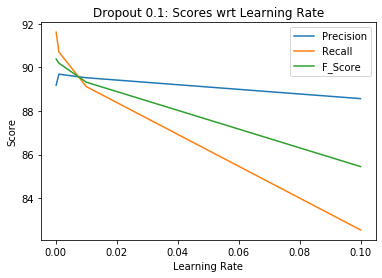

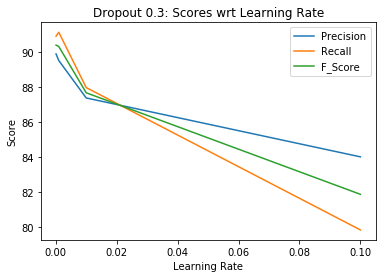

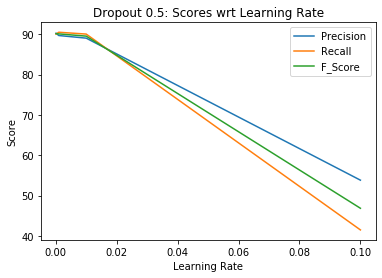

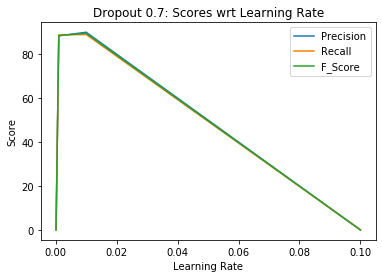

In [ ]:
### DROP THE ROWS OF JUST 0s

print('Plot columns wrt same dropout, different learning rates')

plt.figure(1)
#plt.subplot(511)
dps1_precision = dps1['Precision'].tolist()
dps1_recall = dps1['Recall'].tolist()
dps1_f = dps1['F_Score'].tolist()
plt.plot(my_lr, dps1_precision, label='Precision')
plt.plot(my_lr, dps1_recall, label='Recall')
plt.plot(my_lr, dps1_f, label='F_Score')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('Dropout 0.1: Scores wrt Learning Rate')
plt.legend()
plt.show()

plt.figure(2)
#plt.subplot(511)
dps3_precision = dps3['Precision'].tolist()
dps3_recall = dps3['Recall'].tolist()
dps3_f = dps3['F_Score'].tolist()
plt.plot(my_lr, dps3_precision, label='Precision')
plt.plot(my_lr, dps3_recall, label='Recall')
plt.plot(my_lr, dps3_f, label='F_Score')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('Dropout 0.3: Scores wrt Learning Rate')
plt.legend()
plt.show()

plt.figure(3)
#plt.subplot(511)
dps5_precision = dps5['Precision'].tolist()
dps5_recall = dps5['Recall'].tolist()
dps5_f = dps5['F_Score'].tolist()
plt.plot(my_lr, dps5_precision, label='Precision')
plt.plot(my_lr, dps5_recall, label='Recall')
plt.plot(my_lr, dps5_f, label='F_Score')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('Dropout 0.5: Scores wrt Learning Rate')
plt.legend()
plt.show()

plt.figure(4)
#plt.subplot(511)
dps7_precision = dps7['Precision'].tolist()
dps7_recall = dps7['Recall'].tolist()
dps7_f = dps7['F_Score'].tolist()
plt.plot(my_lr, dps7_precision, label='Precision')
plt.plot(my_lr, dps7_recall, label='Recall')
plt.plot(my_lr, dps7_f, label='F_Score')
plt.xlabel('Learning Rate')
plt.ylabel('Score')
plt.title('Dropout 0.7: Scores wrt Learning Rate')
plt.legend()
plt.show()


Repeating the above with respect to learning rate.  Note that we expect the lower learning rates to have the best scores

Plot columns wrt same learning rates, different dropout


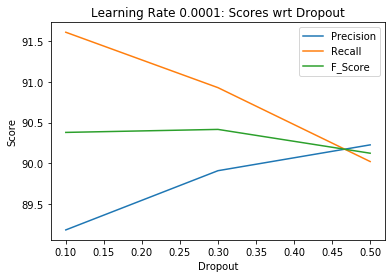

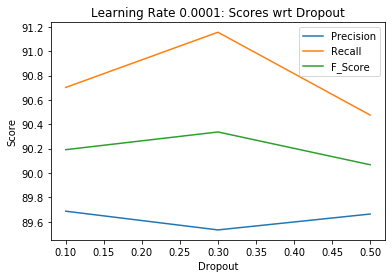

In [ ]:
#no_test

my_lr = [0.0001, 0.001, 0.01, 0.1]
my_dps = [0.1, 0.3, 0.5]

#Note: added [0:3] to the backs of tolist() in order to drop the dropouts of 0
print('Plot columns wrt same learning rates, different dropout')
plt.figure(1)
#plt.subplot(511)
lr0001_precision = lr0001['Precision'].tolist()[0:3]
lr0001_recall = lr0001['Recall'].tolist()[0:3]
lr0001_f = lr0001['F_Score'].tolist()[0:3]
plt.plot(my_dps, lr0001_precision, label='Precision')
plt.plot(my_dps, lr0001_recall, label='Recall')
plt.plot(my_dps, lr0001_f, label='F_Score')
plt.xlabel('Dropout')
plt.ylabel('Score')
plt.title('Learning Rate 0.0001: Scores wrt Dropout')
plt.legend()
plt.show()

plt.figure(2)
#plt.subplot(511)
lr001_precision = lr001['Precision'].tolist()[0:3]
lr001_recall = lr001['Recall'].tolist()[0:3]
lr001_f = lr001['F_Score'].tolist()[0:3]
plt.plot(my_dps, lr001_precision, label='Precision')
plt.plot(my_dps, lr001_recall, label='Recall')
plt.plot(my_dps, lr001_f, label='F_Score')
plt.xlabel('Dropout')
plt.ylabel('Score')
plt.title('Learning Rate 0.0001: Scores wrt Dropout')
plt.legend()
plt.show()

Repeat the above but focus in on the plateua around 90, ignore the drop to 0

Plot columns wrt same learning rates, different dropout


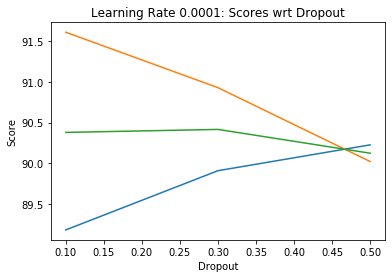

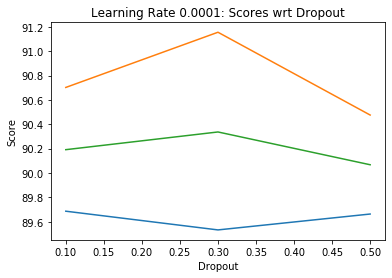

In [ ]:
#no_test

#Updated to drop ones we don't care about
my_lr = [0.0001, 0.001, 0.01, 0.1]
my_dps = [0.1, 0.3, 0.5]

print('Plot columns wrt same learning rates, different dropout')
plt.figure(1)
#plt.subplot(511)
lr0001_precision = lr0001['Precision'].tolist()[0:3]
lr0001_recall = lr0001['Recall'].tolist()[0:3]
lr0001_f = lr0001['F_Score'].tolist()[0:3]
plt.plot(my_dps, lr0001_precision, label='Precision')
plt.plot(my_dps, lr0001_recall, label='Recall')
plt.plot(my_dps, lr0001_f, label='F_Score')
plt.xlabel('Dropout')
plt.ylabel('Score')
plt.title('Learning Rate 0.0001: Scores wrt Dropout')
plt.show()

plt.figure(2)
#plt.subplot(511)
lr001_precision = lr001['Precision'].tolist()[0:3]
lr001_recall = lr001['Recall'].tolist()[0:3]
lr001_f = lr001['F_Score'].tolist()[0:3]
plt.plot(my_dps, lr001_precision, label='Precision')
plt.plot(my_dps, lr001_recall, label='Recall')
plt.plot(my_dps, lr001_f, label='F_Score')
plt.xlabel('Dropout')
plt.ylabel('Score')
plt.title('Learning Rate 0.0001: Scores wrt Dropout')
plt.show()

In [ ]:
#no_test

#This block hasn't been written yet, will do the above but as a callable function
#Note that history_df is wrong, needs to be updated on every run, not just overwriting a new copy...

#load saved model and performance metrics if desired:
#this_model_dir = 'models/42-initial-model/4e0f496_dp0.4_lr0.0003'
#nlp_model = load_model(this_model_dir)
#perf_df = read_csv(this_model_dir + '\perf_df.csv')

#perf_df.set_index('cycle_no', drop=True, inplace=True)
#perf_df.head()

#Plotting
#Columns: cycle_no avg_cycle_loss precission recall f_score dropout learning_rate

#Note that training curves already exist in NB 42:

#scale the losses a bit just to see things together
#perf_df['loss_scaled'] = perf_df['avg_cycle_loss']/10
#perf_df.drop(columns=['avg_cycle_loss']).plot()

In [ ]:
#no_test

from nbdev.export import notebook2script
notebook2script()

Converted 12-ssda-xml-parser.ipynb.
Converted 31-collate-xml-entities-spans.ipynb.
Converted 33-split-data.ipynb.
Converted 41-generic-framework-for-spacy-training.ipynb.
Converted 42-initial-model.ipynb.
Converted 51-data-preprocessing.ipynb.
Converted 52-unstructured-to-markup.ipynb.
Converted 53-markup-to-spatial-historian.ipynb.
Converted 54-utility-functions.ipynb.
Converted 61-prodigy-output-training-demo.ipynb.
Converted 62-full-model-application-demo.ipynb.
Converted 63-pt-model-training.ipynb.
Converted 64-es-model-training.ipynb.
Converted 65-all-annotations-model-training.ipynb.
Converted 66-es-guatemala-model-training.ipynb.
Converted 67-death-and-birth-records-together.ipynb.
Converted 70-exhaustive-training.ipynb.
Converted 71-relationship-builder.ipynb.
Converted 72-full-volume-processor.ipynb.
